In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.signal import stft, istft

In [2]:
import tensorflow as tf

In [50]:
import os

sampling_rate = 44100


def get_vocals_mask(Zxx, threshold=1):
    binary_mask = (np.abs(Zxx) > threshold).astype(float)
    return binary_mask

def get_ideal_binary_mask(Zxx_vocals, Zxx_mix, threshold=0.7):
    binary_mask = (np.abs(Zxx_vocals) > threshold * np.abs(Zxx_mix)).astype(float)
    return binary_mask

def get_inverse_mask(binary_mask):
    return (binary_mask == 0).astype(float)

def get_track_list():
    return ['data/musdb/musdb18hq/train/' + track + '/mixture.wav' for track in os.listdir('data/musdb/musdb18hq/train')]

def read_track(filename):
    directory = f'data/musdb/musdb18hq/train/{filename}'
    sample_rate, vocals = wav.read(f'{directory}/vocals.wav')
    sample_rate, mix = wav.read(f'{directory}/mixture.wav')

    return sample_rate, mix, vocals

def transform_track(signal, sample_rate, nperseg=2048, noverlap=2048 // 2):
    frequencies, times, Zxx_l = stft(signal[:, 0], fs=sample_rate, nperseg=nperseg, noverlap=noverlap, window='hamming')
    frequencies, times, Zxx_r = stft(signal[:, 1], fs=sample_rate, nperseg=nperseg, noverlap=noverlap, window='hamming')

    return frequencies, times, Zxx_l, Zxx_r

def plot_spectogram(times, frequencies, Zxx, segment=None, freq_limit=4000, log=False):
    plt.figure(figsize=(12, 6))
    Zxx_for_plot = np.abs(Zxx[:, segment[0]:segment[1]]) if segment else np.abs(Zxx)
    Zxx_for_plot = np.log10(Zxx_for_plot + 1e-6) if log else Zxx_for_plot
    times_for_plot = times[segment[0]:segment[1]] if segment else times
    plt.pcolormesh(times_for_plot, frequencies, Zxx_for_plot, shading='gouraud', cmap='Greys_r')
    plt.title('STFT Magnitude of Music Track')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Magnitude')
    plt.ylim([0, freq_limit])  # Adjust the frequency range for visualization, if necessary
    plt.show()

def get_window_data(Zxx, window_size=5):
    transposed_stft = Zxx.T
    index_list = range(transposed_stft.shape[0] - window_size)
    windows = np.zeros((len(index_list), window_size, transposed_stft.shape[1]), dtype=complex)
    
    for i in index_list:
        windows[i] = transposed_stft[i:i+window_size]

    return windows


In [87]:
audio_files = ['data/musdb/musdb18hq/train/' + track + '/mixture.wav' for track in os.listdir('data/musdb/musdb18hq/train')]


def read_tf_file(file_path):
    file_path = file_path.numpy().decode("utf-8")
    sr, audio = wav.read(file_path)
    
    return audio.astype(np.float32)

def stft_transform(signal, sample_rate=44100, nperseg=2048, noverlap=2048 // 2):
    frequencies, times, Zxx_l = stft(signal[:, 0], fs=sample_rate, nperseg=nperseg, noverlap=noverlap, window='hamming')
    frequencies, times, Zxx_r = stft(signal[:, 1], fs=sample_rate, nperseg=nperseg, noverlap=noverlap, window='hamming')
    return Zxx_l, Zxx_r

def process_audio(file_path):
    audio = read_tf_file(file_path)
    Zxx_l, Zxx_r = stft_transform(audio)
    return tf.abs(Zxx_l), tf.abs(Zxx_r)

def process_with_tf(file_path):
    stft_left, stft_right = tf.py_function(
        func=process_audio, inp=[file_path], Tout=(tf.float32, tf.float32)
    )
    left_ds = tf.data.Dataset.from_tensor_slices(tf.transpose(stft_left))
    right_ds = tf.data.Dataset.from_tensor_slices(tf.transpose(stft_right))
    return left_ds.concatenate(right_ds)

In [88]:
dataset = tf.data.Dataset.from_tensor_slices(audio_files)

In [89]:
dataset = dataset.flat_map(process_with_tf)

In [90]:
for batch in dataset.take(2):
    print(batch)

tf.Tensor(
[ 6.582613    9.963668   12.921914   ...  0.11070602  0.08848926
  0.1071283 ], shape=(1025,), dtype=float32)
tf.Tensor(
[ 0.09238931  8.8816395  12.036373   ...  0.06635602  0.06292893
  0.07321033], shape=(1025,), dtype=float32)


In [25]:
dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [26]:
dataset.take(1)

<_TakeDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [203]:
tracks = get_track_list()
sample_rate, mix, vocals = read_track(tracks[0])

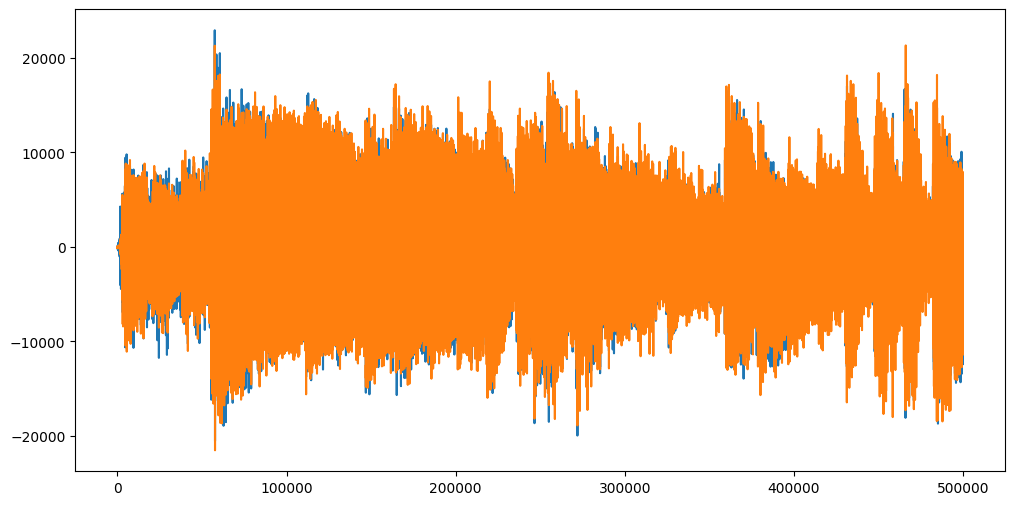

In [205]:
plt.figure(figsize=(12, 6))
plt.plot(mix[:500000])

In [206]:
frequencies, times, Zxx_l, Zxx_r = transform_track(mix, sample_rate)
frequencies_v, times_v, Zxx_l_vocals, Zxx_r_vocals = transform_track(vocals, sample_rate)

In [207]:
Zxx_l_vocals.shape

(1025, 7385)

In [187]:
times[85]

1.9736961451247166

In [188]:
sample_rate

44100

In [194]:
22000 / frequencies.shape[0]

21.463414634146343

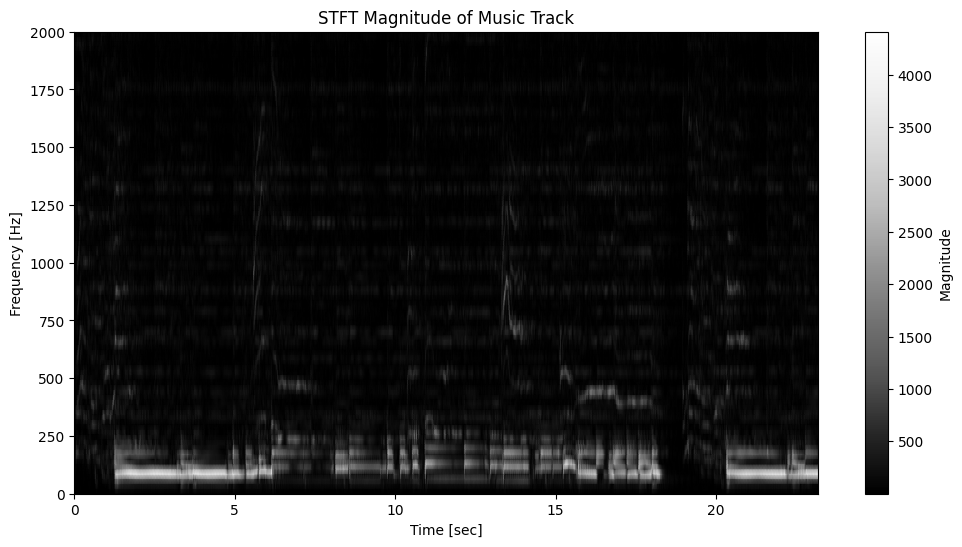

In [190]:
plot_spectogram(times, frequencies, Zxx_l, segment=[0, 1000], freq_limit=2000)

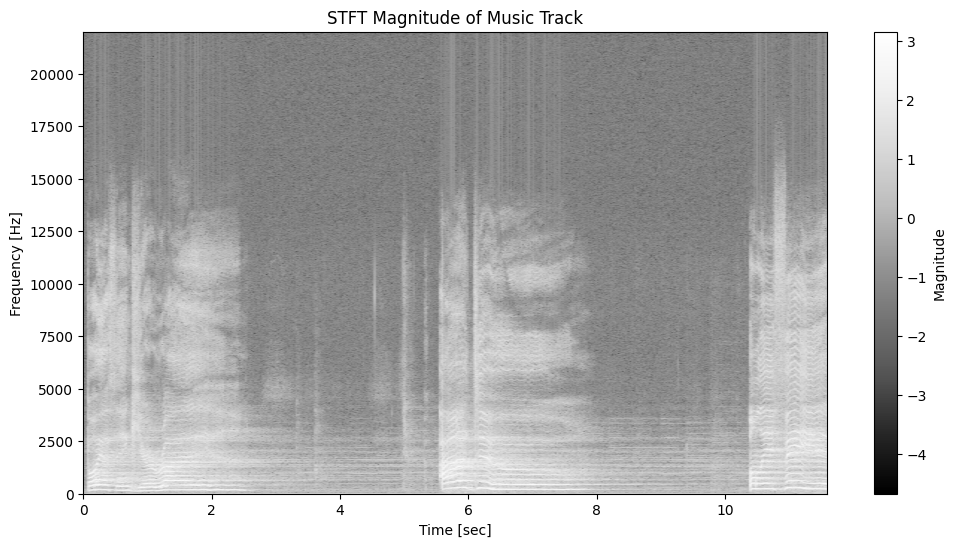

In [131]:
plot_spectogram(times, frequencies, Zxx_l_vocals, segment=[0, 500], freq_limit=22000, log=True)

In [ ]:
binary_mask_l = get_vocals_mask(Zxx_l_vocals, threshold=38)
inverse_mask_l = get_inverse_mask(binary_mask_l)

In [482]:
binary_mask_r = get_vocals_mask(Zxx_r_vocals, threshold=38)
inverse_mask_r = get_inverse_mask(binary_mask_r)

In [84]:
binary_mask_l = get_ideal_binary_mask(Zxx_l_vocals, Zxx_l)
inverse_mask_l = get_inverse_mask(binary_mask_l)
binary_mask_r = get_ideal_binary_mask(Zxx_r_vocals, Zxx_r)
inverse_mask_r = get_inverse_mask(binary_mask_r)

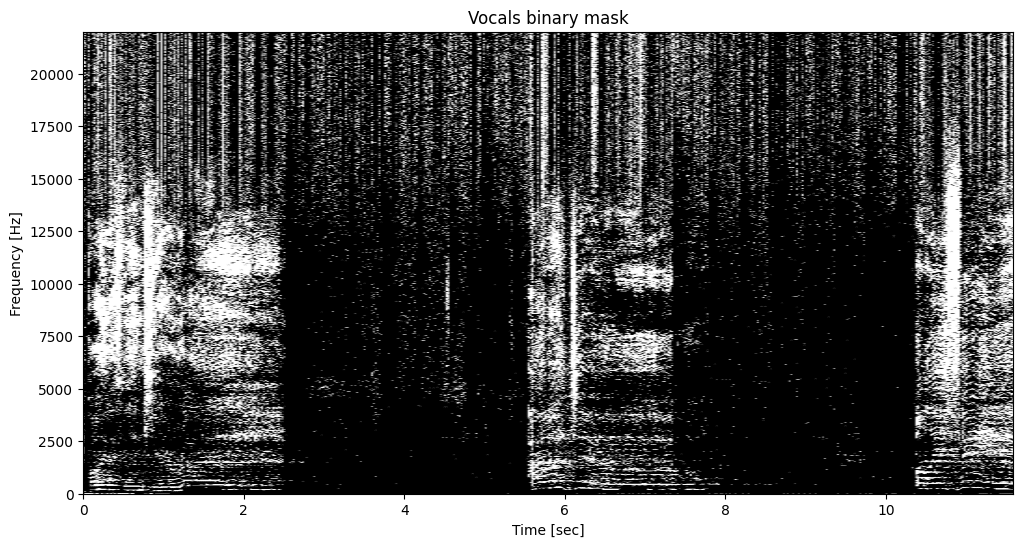

In [195]:
plt.figure(figsize=(12, 6))
plt.pcolormesh(times[0:500], frequencies, binary_mask_l[:, 0:500], shading='gouraud', cmap='Greys_r')
plt.title('Vocals binary mask')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0, 22000])  # Adjust the frequency range for visualization, if necessary
plt.show()

In [89]:
np.abs(Zxx_l)

array([[ 6.582613  ,  0.09238931,  1.5980332 , ...,  2.531391  ,
         2.99744   ,  1.1385171 ],
       [ 9.963668  ,  8.8816395 ,  8.317821  , ...,  9.910396  ,
         8.909297  ,  1.1053641 ],
       [12.921914  , 12.036373  ,  8.998367  , ...,  9.574142  ,
         7.937273  ,  1.0120138 ],
       ...,
       [ 0.11070602,  0.06635602,  0.32894754, ...,  0.04264395,
         0.10551779,  0.01454928],
       [ 0.08848926,  0.06292893,  0.10698577, ...,  0.08268292,
         0.10688145,  0.01620791],
       [ 0.1071283 ,  0.07321033,  0.3456448 , ...,  0.1969335 ,
         0.15354832,  0.01679248]], dtype=float32)

In [76]:
Zxx_l * inverse_mask_l

array([[-1.22463999e+01+0.00000000e+00j, -3.82697639e+01+0.00000000e+00j,
        -8.46482754e+00+0.00000000e+00j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 1.27506084e+01-5.35466576e+00j,  3.45420790e+00-6.05539551e+01j,
        -1.36726608e+02-2.79947754e+02j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [-3.98280168e+00+1.02166758e+01j,  5.43301506e+01-9.86843586e+00j,
         8.22334229e+02+5.33184631e+02j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       ...,
       [-1.92450196e-03-1.62227021e-03j, -5.31767309e-01+3.98419201e-01j,
         1.22284189e-01-6.46945953e-01j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [-6.18242053e-03+4.08151606e-03j, -4.

In [77]:
_, reconstructed_instrumental_l = istft(Zxx_l * inverse_mask_l, fs=sample_rate, nperseg=2048, noverlap=2048 // 2)
_, reconstructed_instrumental_r = istft(Zxx_r * inverse_mask_r, fs=sample_rate, nperseg=2048, noverlap=2048 // 2)
_, reconstructed_vocals_l = istft(Zxx_l_vocals * binary_mask_l, fs=sample_rate, nperseg=2048, noverlap=2048 // 2)
_, reconstructed_vocals_r = istft(Zxx_r_vocals * binary_mask_r, fs=sample_rate, nperseg=2048, noverlap=2048 // 2)

In [78]:
reconstructed_instrumental = np.stack([reconstructed_instrumental_l, reconstructed_instrumental_r], axis=-1)
reconstructed_vocals = np.stack([reconstructed_vocals_l, reconstructed_vocals_r], axis=-1)

In [79]:
wav.write('data/reconstructed_instrument.wav', sample_rate, reconstructed_instrumental.astype(np.int16))
wav.write('data/reconstructed_vocals.wav', sample_rate, reconstructed_vocals.astype(np.int16))

## Training model (DEPRICATED)

In [161]:
import tensorflow as tf
from tensorflow.keras import layers

In [180]:
phase = np.angle(Zxx_mix_l)

In [ ]:
np.abs(Zxx_mix_l.T)

array([[7.20072687e-02, 1.03112087e-01, 3.36001221e+02, ...,
        2.96967468e+01, 1.34453131e-02, 9.99650266e-03],
       [1.03293687e-01, 1.39495701e-01, 3.82542267e+02, ...,
        3.50405807e+01, 1.10318094e-01, 4.88707470e-03],
       [8.94766599e-02, 1.90056264e-01, 7.06769348e+02, ...,
        5.68432617e+01, 1.46722868e-01, 2.34339200e-02],
       ...,
       [1.02554550e-02, 1.20503418e-02, 1.32072017e-01, ...,
        2.63746269e-02, 2.22338792e-02, 5.14573278e-03],
       [4.18184511e-03, 1.44969244e-02, 1.09591618e-01, ...,
        2.80912202e-02, 1.68655179e-02, 4.97783814e-03],
       [6.41495804e-04, 7.15168659e-03, 1.25041023e-01, ...,
        4.79800403e-02, 2.81296996e-03, 4.55306750e-03]], dtype=float32)

In [240]:
nn = tf.keras.Sequential([
    layers.InputLayer((Zxx_mix_l.shape[0],)),
    # layers.Resizing(41, 25),
    # layers.Normalization(),
    # layers.Conv2D(32, 3, activation='relu'),
    # layers.MaxPooling2D(),
    layers.Dense(256, activation='sigmoid'),
    layers.Dropout(0.1),
    layers.Dense(Zxx_vocals.shape[0]),
])
nn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [241]:
nn.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 256)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1025)           │       263,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,081 (2.01 MB)

 Trainable params: 526,081 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [245]:
history = nn.fit(
    np.abs(Zxx_mix_l.T),
    np.abs(Zxx_vocals.T),
    epochs=10,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.9390 - val_loss: 5.1687
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.7457 - val_loss: 5.0674
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.5880 - val_loss: 5.0651
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.6596 - val_loss: 5.0656
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.6562 - val_loss: 4.9452
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.6672 - val_loss: 5.0109
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.5181 - val_loss: 5.0450
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.6526 - val_loss: 5.0166
Epoch 9/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.5914 - val_loss: 5.0005
Epoch 10/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.6065 - val_loss: 5.0518
